In [1]:
import sys
sys.path.append('../')
from template_project import plotters, tools, utilities, writers, readers
import importlib

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.colors import BoundaryNorm
import palettable as palette
import pandas as pd

# After editing your_module_name.py, reload it:
importlib.reload(plotters)

obsidiandirec = 'C:/Users/m300892/Documents/PhD/Obsidian/PhD/Images/'

In [2]:
# Load gliderdata of churchill (containing w, MLD from a density threshold (0.01) and MLD_manually selected)
ds                  = readers.read_glider('churchill')
# Load ERA5 datasets in the LabSea of years 2021/2022
ds_wind, ds_heat    = readers.read_ERA5()
# Load high pass filtered vertical velocity data from churchill
ds_hp               = readers.read_hp_w()

In [27]:
# Warm & Fresher time with consistent MLD probably due to an eddy
eddy_start          = pd.to_datetime("2022-01-10T00:00:00") 
eddy_end            = pd.to_datetime("2022-01-25T00:00:00")

# Deepening of the mixed layer
conv_deepen_start   = pd.to_datetime('2022-01-30T00:00:00')
conv_deepen_end     = pd.to_datetime('2022-02-25T00:00:00')

# Second deepening of the mixed layer (after a shallower period)
conv_deepen_start_2 = pd.to_datetime('2022-02-25T00:00:00')
conv_deepen_end_2 = pd.to_datetime('2022-03-13T00:00:00')

# Shallowing of the mixed layer
conv_shallow_start = pd.to_datetime('2022-03-13T00:00:00')
conv_shallow_end = pd.to_datetime('2022-04-01T00:00:00')


min_perc = 0.01          # Minimum percentage of data within the rolling window at most common resolution
outer_window_min = 60*3 # Outer window size in minutes
inner_window_min = 5    # Inner window size in minutes
resolution = 2          # Sampling resolution in seconds (needed to calc the minimum number of observations in a rolling window)
glidername= 'L1398'     # Name of the glider

config = {
    "rolling_window_outer"     : f"{outer_window_min}min",           # 6H choosen by Steffen
    "rolling_window_inner"     : f"{inner_window_min}min",           # 1H, choosen by steffen's
    "rolling_min_periods_outer": int(outer_window_min*min_perc*60),  # Minimum number of observations within the outer rolling window (data before: in hours or see inner window)
    "rolling_min_periods_inner": int((inner_window_min/60)*(3600*1/resolution)*min_perc),  # Minimum number of observations within the inner rolling window (data before: in seconds or see most common time difference)
    
    "var"               : 'w',
    "data_in"           : ds, 
    "data_wind"         : ds_wind,
    "data_heat"         : ds_heat,
    "start_time"        : conv_deepen_start_2, 
    "end_time"          : conv_deepen_end_2, 
    "interp_method"     : "linear",
    "depth_min"         : 50,  # Drop upper 50m (wave effects, etc.)
    "max_lag"           : 24 * 3,
    "freq"              : 'H',
    "add_ext_interp"    : False, #True,
    "variables_to_keep" : ['salinity', 'temperature', 'density', 'depth', 'latitude', 'longitude', 'time', 'MLD', 'w', 'profile_direction', 'MLD_manual', 'profile_index'], #if None it keeps the standard variables
}
# Preprocess data
ds_398                                                          = tools.preprocess_data(config)
# Interpolate ERA5 onto hourly positions of the glider
resample_time, series_wind, series_heat                         = tools.interpolate_onto_track(ds_398, config)

# Calculate vertical velocity variance
mld_var = 'MLD_manual' #or 'MLD'
series_w_prime, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_398, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
# Calculate vertical velocity variance masking just before the interpolation (thus including more values from outside the ML)
series_w_prime_masklater, _ , intermediates_mask_later          = tools.get_wprime_timeseries_update_2(resample_time,ds_398, config, debug=True, mld_var=mld_var)
# Calculate vertical velocity variance without any masking
wprime_rms                                                      = tools.calculate_wprime(ds_398, config, return_mask=False)

filter depths shallower than: 50 dbar


In [28]:
# ds_shallow = ds_398.where(((ds_398['depth'] <= 200) & (ds_398['depth'] > 100)) , drop=True) #& (ds_398['depth']>600))
depth_max = 60
ds_mld = ds_398.where((ds_398['depth'] < ds_398['MLD_manual']), drop=True)
ds_shallow = ds_mld#.where((ds_mld['depth'] <= depth_max) & (ds_mld['depth']>depth_max-100) , drop=True) #

series_w_prime_shallow, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_shallow, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
# Calculate vertical velocity variance without any masking
wprime_rms_shallow                                                      = tools.get_wprime_timeseries(resample_time, ds_shallow, config, return_mask=False)

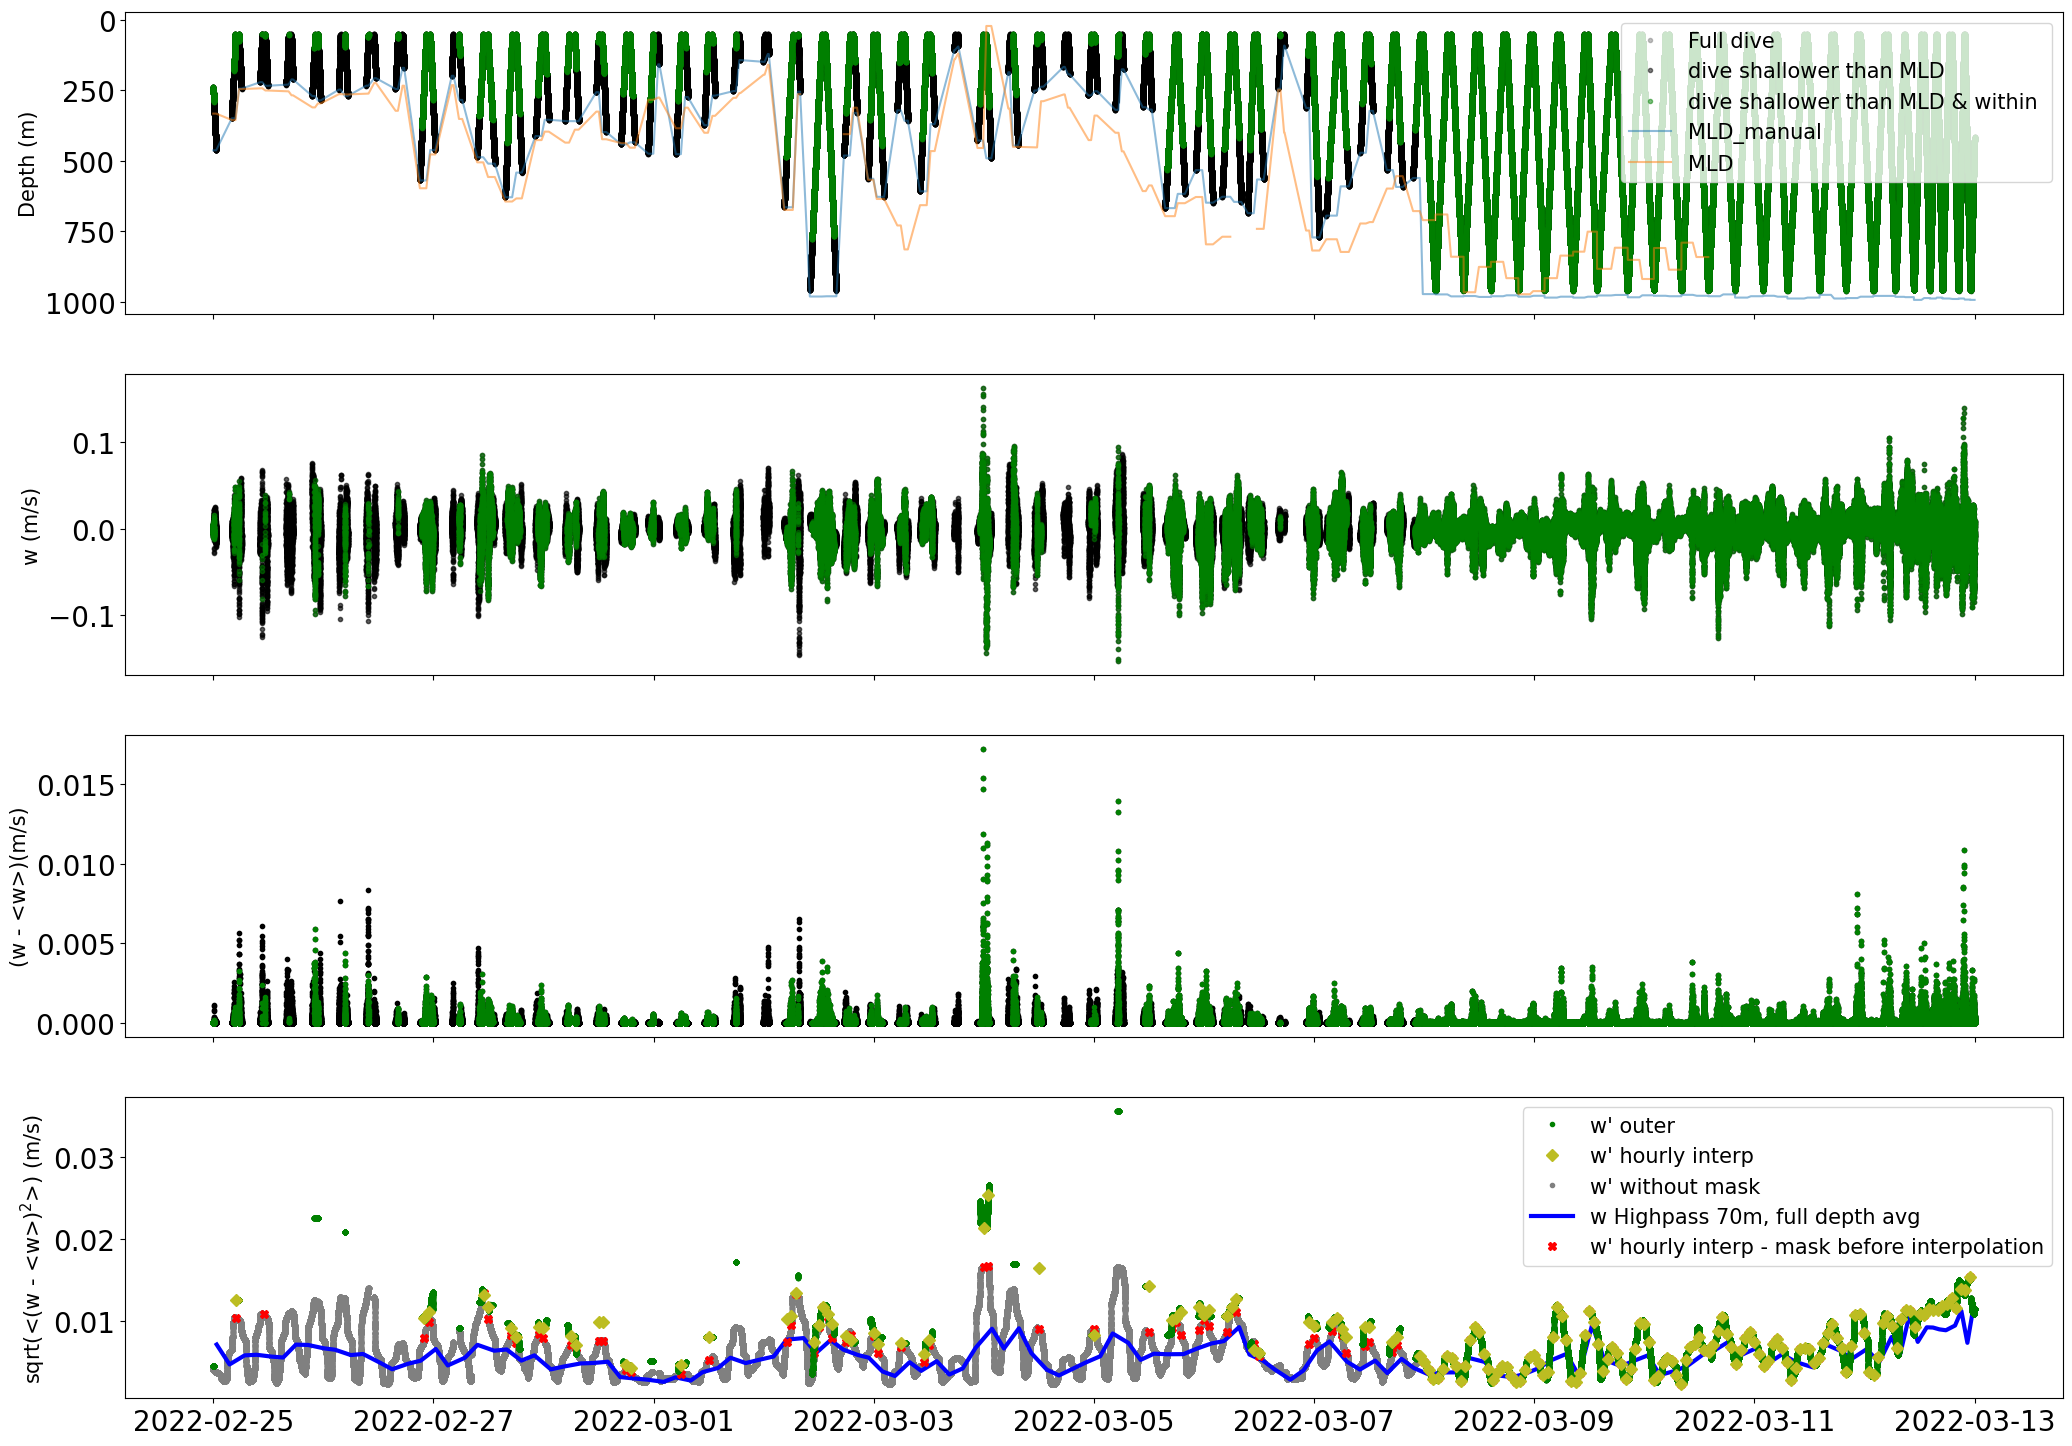

In [29]:
ds_hp_sel = ds_hp.isel({'profile_index' : (ds_hp['mid_times'] >= config['start_time']) & (ds_hp['mid_times'] <= config['end_time'])}, drop=True)
fig, ax = plotters.plot_lag_correlation_steps(intermediates, ds_shallow, 
                                                   wprime_rms=wprime_rms, 
                                                   series_2 = series_w_prime_masklater, 
                                                   ds_hp = ds_hp_sel,
                                                   mld_var=['MLD_manual','MLD'])
# Set x limit to zoom in
#ax[0].set_xlim(config['start_time'], config['end_time'])
# ax[0].set_xlim(pd.to_datetime('2022-03-05T00:00:00'), pd.to_datetime('2022-03-15T00:00:00'))

[range(-72, 73), range(-72, 73)] [[0.03520300664273655, 0.03987023516871022, 0.052662001027802524, 0.09504315828416837, 0.12146160450491605, 0.1231458407862182, 0.1046366164348851, 0.08028207651835793, 0.060557626083688795, 0.05359156048119176, 0.04479449301570269, 0.02232774746148557, -0.004790619341438124, -0.038874686285405, -0.06540078089492089, -0.07853126986338661, -0.07328670366513156, -0.06999803698444773, -0.07253449610171284, -0.06450818756268677, -0.0644608970230608, -0.07189713290257178, -0.07382545542964858, -0.0768188738185926, -0.08060005263523433, -0.07766104885727369, -0.0753180780347054, -0.063160736563639, -0.04283648537435418, -0.034729237160083, -0.03523784194558376, -0.03332363626460557, -0.027629000363213925, -0.027131373769357436, -0.038146284667900786, -0.04738881459832057, -0.03375434333324429, -0.029033122086432234, -0.0209963254162462, -0.021677203468179366, -0.03737898354313949, -0.057667369596575806, -0.08237131275981001, -0.09725699753129412, -0.103716121

Text(-0.01, -0.15, 'MLD variable: MLD_manual\nResolution = 2s\nOuter window = 180 min\nInner window = 5 min\nMin % data = 1.0%\nRolling min periods (outer) = 108\n')

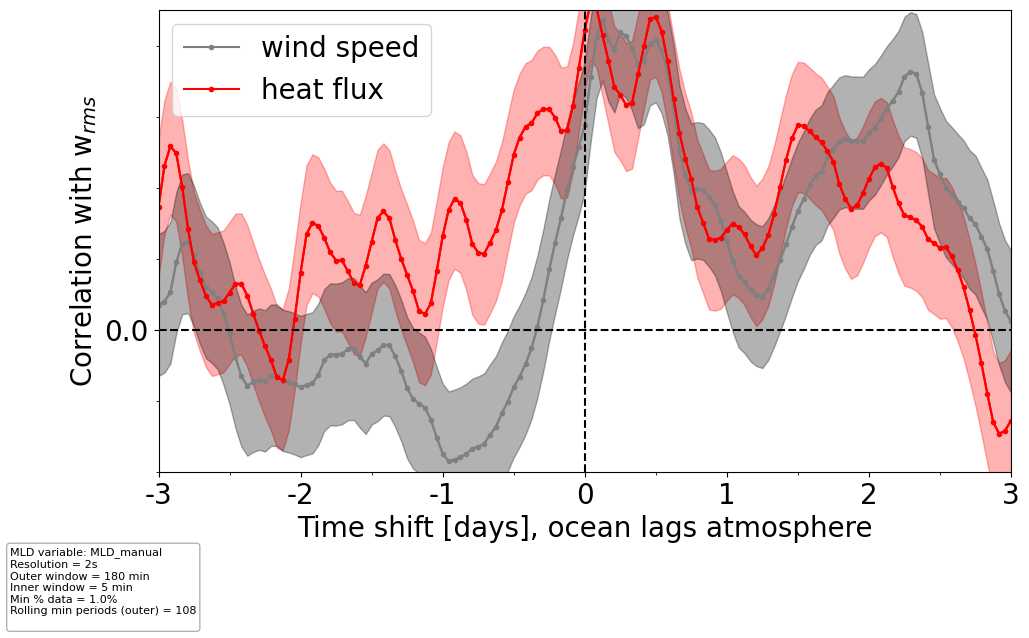

In [30]:
import importlib
fontsize = 20  # Adjust as needed
import matplotlib
# Set font size globally
matplotlib.rcParams.update({'font.size': fontsize})
lags_heat, corrs_heat       = tools.lag_correlation(series_w_prime_shallow, series_heat, max_lag=config['max_lag'])
lags_wind, corrs_wind       = tools.lag_correlation(series_w_prime_shallow, series_wind, max_lag=config['max_lag'])
# Plot the correlation
corr_dict2 = {'lags':            [lags_wind, lags_heat], 
             'correlations':     [corrs_wind, corrs_heat],
             'labels':           ['wind speed', 'heat flux'],}
plot_dict2 = {'ylim':(-0.2,0.45), 'colors': ['grey','red'], 'xlim': [-24*3, 24*3]}
fig, ax = plotters.plot_corr(corr_dict2, plot_dict2)
upper_r, lower_r = tools.confid_interval(corrs_heat, len(series_heat))
upper_r_interp, lower_r_interp = tools.confid_interval(corrs_wind, len(series_heat))
ax.fill_between(lags_heat, upper_r, lower_r, color='r', alpha=0.3)
ax.fill_between(lags_wind, upper_r_interp, lower_r_interp, color='k', alpha=0.3)

# make a nice multi-line string from the config
textstr = (
    # f"Glider: {glidername}\n"
    f"MLD variable: {mld_var}\n"
    f"Resolution = {resolution}s\n"
    f"Outer window = {outer_window_min} min\n"
    f"Inner window = {inner_window_min} min\n"
    f"Min % data = {min_perc*100:.1f}%\n"
    f"Rolling min periods (outer) = {config['rolling_min_periods_outer']}\n"
    #f"Rolling min periods (inner) = {config['rolling_min_periods_inner']}"
    # f"Time range: {eddy1.date()} → {eddy2.date()}"
)
# add text at figure level (outside the axes)
fig.text(
    -0.01, -0.15, textstr,
    fontsize=8, va="bottom", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6, edgecolor="gray")
)
#fig.savefig(obsidiandirec + f'churchill_time_lag_{config['start_time'].strftime('%Y%m%d')}_{config['end_time'].strftime('%Y%m%d')}_full.png')

### This code can be run seperately - It gives us the time-lags for different depths
-- next could be correlation with temperature. This about what gliding motion of glider means here!

In [ ]:
(100/0.004)/(60*60) #would take 7h for a velocity of 0.004 to cover 100m

6.944444444444445

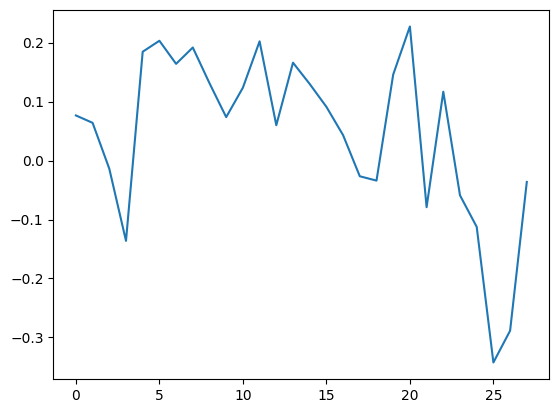

In [ ]:

plt.plot(corrs_heats_all[1,:,0])

In [265]:
dz = 20
min_perc = 0.01          # Minimum percentage of data within the rolling window at most common resolution
outer_window_min = 20 # Outer window size in minutes
inner_window_min = 5    # Inner window size in minutes
resolution = 2          # Sampling resolution in seconds (needed to calc the minimum number of observations in a rolling window)
glidername= 'L1398'     # Name of the glider
mld_var = 'MLD_manual'
plot_figure = False

config = {
    "rolling_window_outer"     : f"{outer_window_min}min",           # 6H choosen by Steffen
    "rolling_window_inner"     : f"{inner_window_min}min",           # 1H, choosen by steffen's
    "rolling_min_periods_outer": int(outer_window_min*min_perc*60),  # Minimum number of observations within the outer rolling window (data before: in hours or see inner window)
    "rolling_min_periods_inner": int((inner_window_min/60)*(3600*1/resolution)*min_perc),  # Minimum number of observations within the inner rolling window (data before: in seconds or see most common time difference)
    
    "var"               : 'w',
    "data_in"           : ds, 
    "data_wind"         : ds_wind,
    "data_heat"         : ds_heat,
    # "start_time"        : start, 
    # "end_time"          : end, 
    "interp_method"     : "linear",
    "depth_min"         : 20,  # Drop upper 50m (wave effects, etc.)
    "max_lag"           : 24 * 3,
    "freq"              : 'H',
    "add_ext_interp"    : False, #True,
    "variables_to_keep" : ['salinity', 'temperature', 'density', 'depth', 'latitude', 'longitude', 'time', 'MLD', 'w', 'profile_direction', 'MLD_manual', 'profile_index'], #if None it keeps the standard variables
}

ds_mld = ds.where((ds['depth'] < ds['MLD_manual']), drop=True)
depths_max = np.arange(config['depth_min']+dz,ds_mld['depth'].max()-dz,dz)
lags  = range(-config['max_lag'], config['max_lag'] + 1)

eddy1 = pd.to_datetime('2022-01-10')
eddy2 = pd.to_datetime('2022-01-25')

deep1 = pd.to_datetime('2022-01-30')
deep2 = pd.to_datetime('2022-02-25')

second_deep1 = pd.to_datetime('2022-02-25')
second_deep2 = pd.to_datetime('2022-03-13')

shoal1 = pd.to_datetime('2022-03-13')
shoal2 = pd.to_datetime('2022-04-01')

veryshoal1 = pd.to_datetime('2022-04-01')
veryshoal2 = pd.to_datetime('2022-04-15')

# time_starts = [eddy1, deep1, second_deep1, shoal1, veryshoal1]
# time_ends = [eddy2, deep2, second_deep2, shoal2, veryshoal2]

weeks = pd.date_range(start=ds.time[0].values, end=ds.time[-1].values, freq="W")
time_starts = weeks[::2]
time_ends = weeks[2::2]

corrs_heats_all = np.full((len(lags),len(depths_max), len(time_starts)), np.nan)
corrs_winds_all = np.full((len(lags),len(depths_max), len(time_starts)), np.nan)


for j in range(len(time_ends)):
    print(j)
    config['start_time'] = time_starts[j]
    config['end_time']   = time_ends[j]

    # Preprocess data
    ds_398                                                          = tools.preprocess_data(config)
    # Interpolate ERA5 onto hourly positions of the glider
    resample_time, series_wind, series_heat                         = tools.interpolate_onto_track(ds_398, config)

    lags  = range(-config['max_lag'], config['max_lag'] + 1)

    ds_mld = ds_398.where((ds_398['depth'] < ds_398['MLD_manual']), drop=True)
    depths = np.arange(config['depth_min']+dz,ds_mld['depth'].max()-dz,dz)

    corrs_heats = np.full((len(lags),len(depths)), np.nan)
    corrs_winds = np.full((len(lags),len(depths)), np.nan)
    for i, depth_max in enumerate(depths):
        #print(i,depth_max, depth_max-dz)
        ds_shallow = ds_mld.where((ds_mld['depth'] <= depth_max) & (ds_mld['depth']>depth_max-dz) , drop=True) #

        #series_w_prime_shallow, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_shallow, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
        # Calculate vertical velocity variance without any masking
        wprime_rms_shallow                                                      = tools.get_wprime_timeseries(resample_time, ds_shallow, config, return_mask=False)
        lags, corrs_heat            = tools.lag_correlation(wprime_rms_shallow, series_heat, max_lag=config['max_lag'])
        lags_wind, corrs_wind       = tools.lag_correlation(wprime_rms_shallow, series_wind, max_lag=config['max_lag'])


        corrs_heats[:,i] = corrs_heat
        corrs_winds[:,i] = corrs_wind
        if plot_figure:
            if i==0:
                # Plot the correlation
                corr_dict2 = {'lags':            [lags, lags], 
                            'correlations':     [corrs_wind, corrs_heat],
                            'labels':           ['wind speed', 'heat flux'],}
                plot_dict2 = {'ylim':(-1,1), 'colors': ['k','red'], 'xlim': [-24*3, 24*3]}
                fig, ax = plotters.plot_corr(corr_dict2, plot_dict2)
                upper_r, lower_r = tools.confid_interval(corrs_heat, len(series_heat))
                upper_r_interp, lower_r_interp = tools.confid_interval(corrs_wind, len(series_heat))
                ax.fill_between(lags, upper_r, lower_r, color='r', alpha=0.3)
                ax.fill_between(lags, upper_r_interp, lower_r_interp, color='k', alpha=0.3)
                fig.savefig(obsidiandirec + f'churchill_time_lag{config['start_time'].strftime('%Y%m%d')}_{config['end_time'].strftime('%Y%m%d')}_{depth_max-dz}_{depth_max}dbar.png')

    corrs_heats_all[:,:len(depths),j] = corrs_heats
    corrs_winds_all[:,:len(depths),j] = corrs_winds
# out = xr.Dataset({'corrs_heat':(['depth_bin','lag'], corrs_heat),
#                   'corrs_wind':(['lag'], corrs_wind)},
#                      coords={'lag':lags_wind, 'depth_bin': depth_max})


0
filter depths shallower than: 20 dbar
1
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

2
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

3
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

4
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

5
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

6
filter depths shallower than: 20 dbar
7
filter depths shallower than: 20 dbar


c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Pr

8
filter depths shallower than: 20 dbar
9
filter depths shallower than: 20 dbar
10
filter depths shallower than: 20 dbar


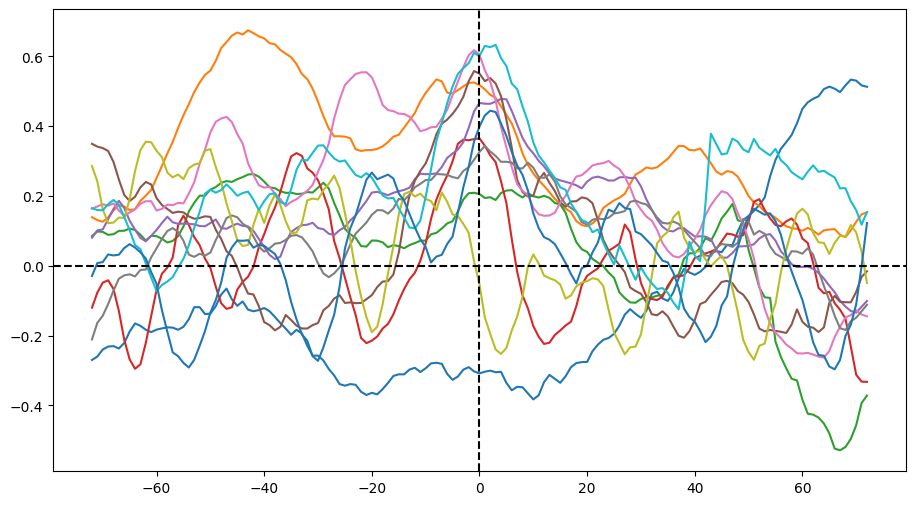

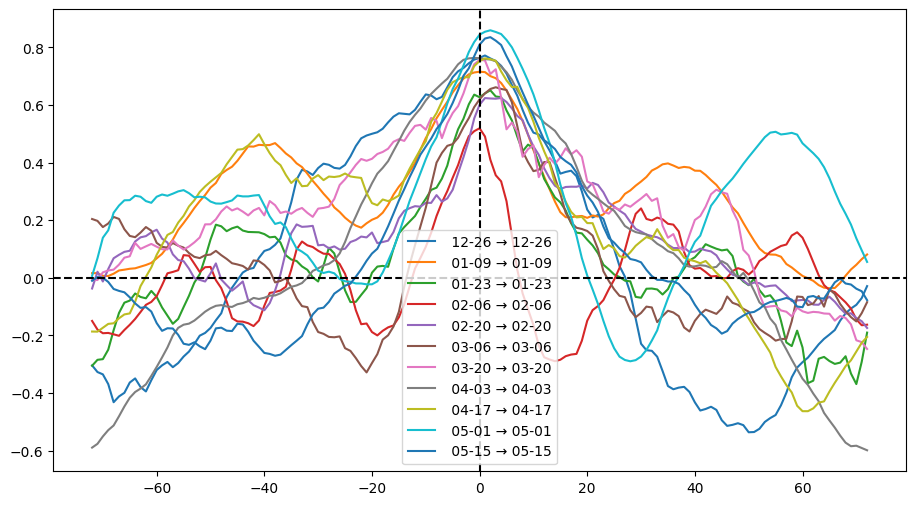

In [253]:
# plt.plot(lags,corrs_heats_all[:,0,:], label=f"{time_starts.strftime('%Y%m%d')}")
fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_ends):
    ax.plot(lags, corrs_heats_all[:, 0, i], label=f' {t.strftime("%m-%d")} → ,{time_ends[i].strftime("%m-%d")}')
# ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_ends):
    ax.plot(lags, corrs_winds_all[:, 0, i], label=f' {t.strftime("%m-%d")} → {time_ends[i].strftime("%m-%d")}')
ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

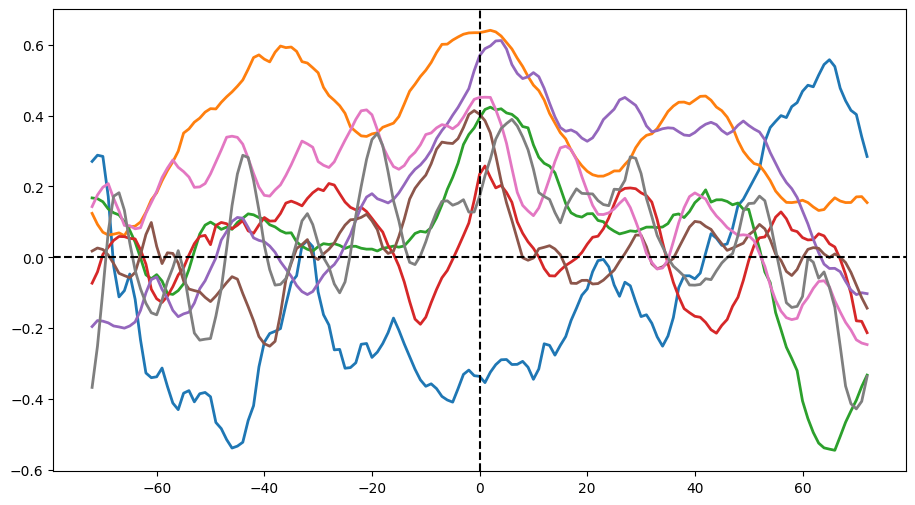

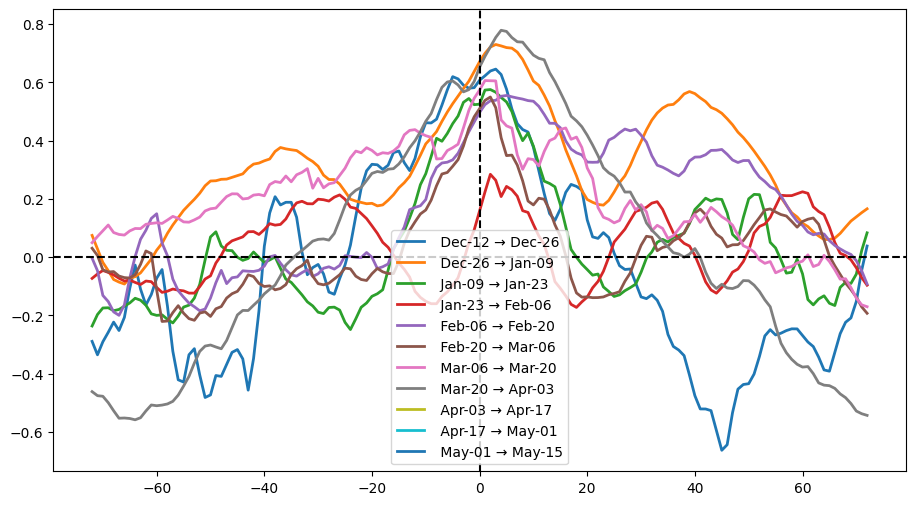

In [261]:
# plt.plot(lags,corrs_heats_all[:,0,:], label=f"{time_starts.strftime('%Y%m%d')}")
j=4
fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_ends):
    ax.plot(lags, corrs_heats_all[:,j, i], label=f' {time_starts[i].strftime("%b-%d")} → ,{time_ends[i].strftime("%b-%d")}', linewidth=2)
# ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_ends):
    ax.plot(lags, corrs_winds_all[:,j, i], label=f' {time_starts[i].strftime("%b-%d")} → {time_ends[i].strftime("%b-%d")}', linewidth=2)
ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

## Only the indicated periods - I also used earlier

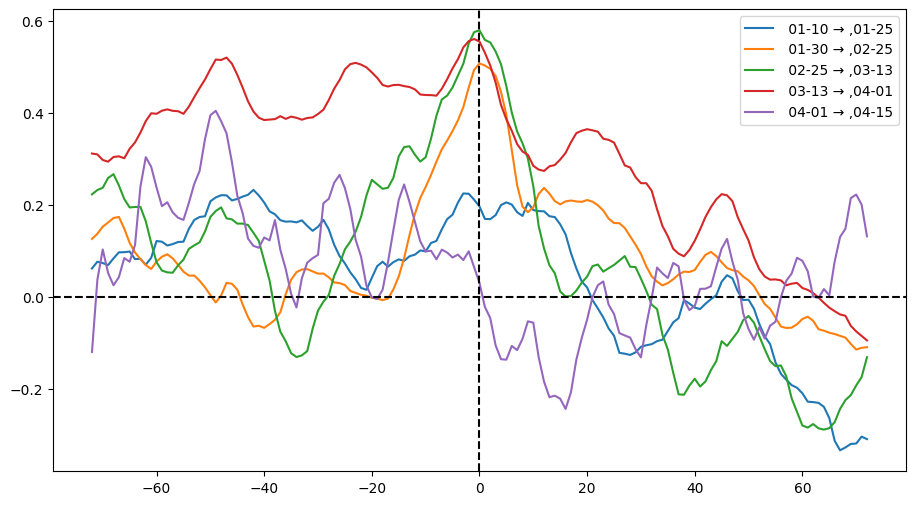

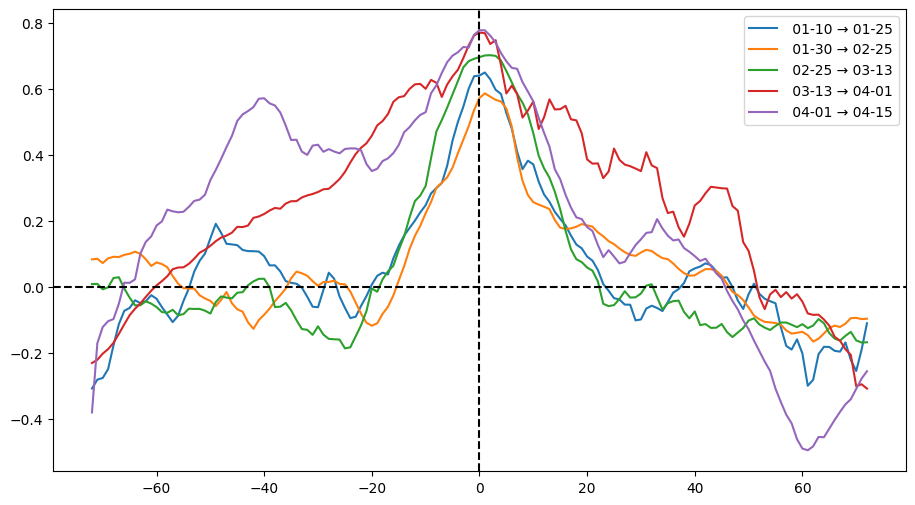

In [239]:
# plt.plot(lags,corrs_heats_all[:,0,:], label=f"{time_starts.strftime('%Y%m%d')}")
fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_starts):
    ax.plot(lags, corrs_heats_all[:, 0, i], label=f' {t.strftime("%m-%d")} → ,{time_ends[i].strftime("%m-%d")}')
ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_starts):
    ax.plot(lags, corrs_winds_all[:, 0, i], label=f' {t.strftime("%m-%d")} → {time_ends[i].strftime("%m-%d")}')
ax.legend()

# Draw horizontal and vertical reference lines at zero
ax.axhline(0, color='k', linestyle='--')
ax.axvline(0, color='k', linestyle='--')

## Is also the average over all depth bins different to my calculation before?

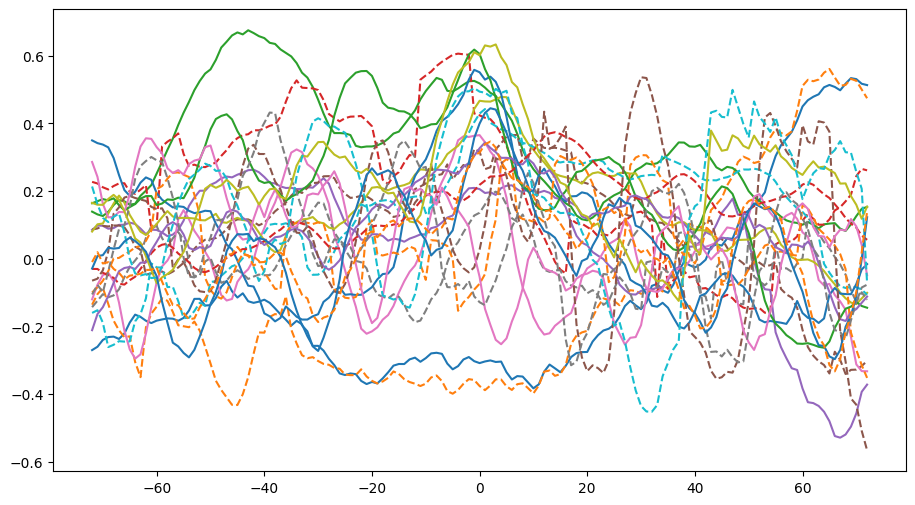

In [271]:
fig, ax = plt.subplots(1,1, figsize=(11, 6))
for i, t in enumerate(time_ends):
    ax.plot(lags, corrs_heats_all[:, 0, i], label=f' {t.strftime("%m-%d")} → ,{time_ends[i].strftime("%m-%d")}')
    ax.plot(lags, np.nanmean(corrs_heats_all[:, :, i],axis=1), '--', label=f' {t.strftime("%m-%d")} → ,{time_ends[i].strftime("%m-%d")}')

In [ ]:
corrs_heats_all[:,0,:]

argmax1 = np.argmax(corrs_heats_all, axis=0)
argmax2 = np.argmax(corrs_winds_all, axis=0)
lag_max_wind = np.full(len(depths),np.nan)
lag_max_heat = np.full(len(depths),np.nan)
for i,depth in enumerate(depths):
    lag_max_wind[i] = lags[argmax2[i]]
    lag_max_heat[i] = lags[argmax1[i]]

array([[ 0.06176604,         nan,         nan,         nan,         nan],
       [ 0.07646279,         nan,         nan,         nan,         nan],
       [ 0.0735411 ,         nan,         nan,         nan,         nan],
       [ 0.06925541,         nan,         nan,         nan,         nan],
       [ 0.08369845,         nan,         nan,         nan,         nan],
       [ 0.09694961,         nan,         nan,         nan,         nan],
       [ 0.09719971,         nan,         nan,         nan,         nan],
       [ 0.09859981,         nan,         nan,         nan,         nan],
       [ 0.08218985,         nan,         nan,         nan,         nan],
       [ 0.08264139,         nan,         nan,         nan,         nan],
       [ 0.06997411,         nan,         nan,         nan,         nan],
       [ 0.08493971,         nan,         nan,         nan,         nan],
       [ 0.12149071,         nan,         nan,         nan,         nan],
       [ 0.11996937,         nan,     

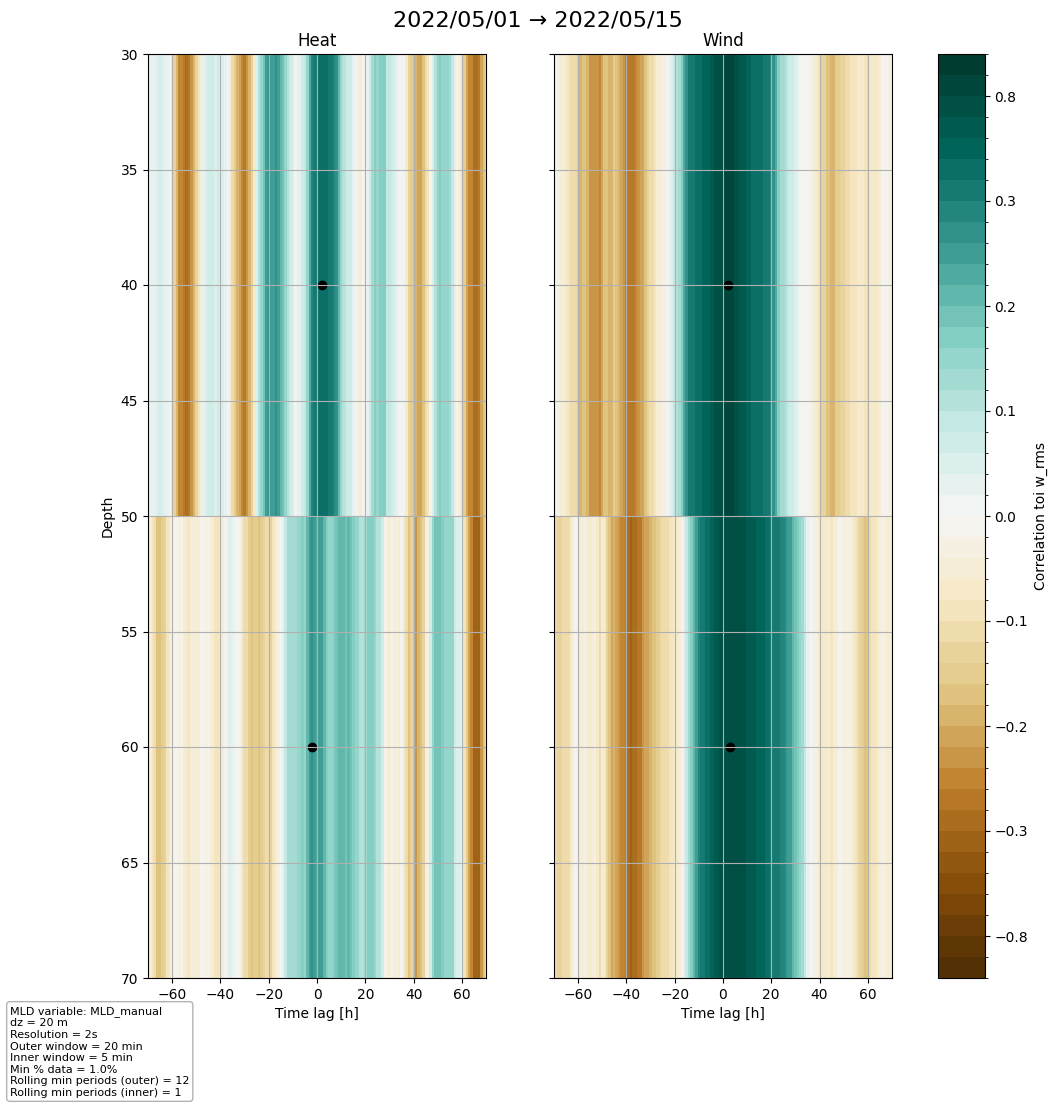

In [266]:
# define the negative side
level1 = np.arange(-1, -0.3, 0.1)   # coarse far from 0
level2 = np.arange(-0.3, 0, 0.02)    # finer near 0
# include zero explicitly
levels_neg = np.concatenate([level1, level2])
levels = np.concatenate([levels_neg, [0], -levels_neg[::-1]])  # mirror to positive side

fig, (ax,ax2) = plt.subplots(1,2, figsize=(12,12), sharex=True, sharey=True)

cmap = palette.colorbrewer.diverging.BrBG_11.mpl_colormap
# Create norm with discrete levels
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
props = dict(norm=norm, cmap=cmap)
ax.pcolormesh(lags, depths, corrs_heats.T, **props)
cbar=ax2.pcolormesh(lags, depths, corrs_winds.T, **props)
fig.colorbar(cbar, ax=[ax,ax2], label='Correlation toi w_rms')

ax.invert_yaxis()
ax.grid()
ax2.grid()
ax2.set_xlabel('Time lag [h]')
ax.set_xlabel('Time lag [h]')
ax2.set_title('Wind')
ax.set_title('Heat')
ax.set_ylabel('Depth')
fig.supxlabel(
    f"{config['start_time'].strftime('%Y/%m/%d')} → {config['end_time'].strftime('%Y/%m/%d')}",
    fontsize=16, y=0.9, x=0.45  # adjust y to control vertical offset
)


# make a nice multi-line string from the config
textstr = (
    # f"Glider: {glidername}\n"
    f"MLD variable: {mld_var}\n"
    f"dz = {dz} m\n"
    f"Resolution = {resolution}s\n"
    f"Outer window = {outer_window_min} min\n"
    f"Inner window = {inner_window_min} min\n"
    f"Min % data = {min_perc*100:.1f}%\n"
    f"Rolling min periods (outer) = {config['rolling_min_periods_outer']}\n"
    f"Rolling min periods (inner) = {config['rolling_min_periods_inner']}"
    # f"Time range: {eddy1.date()} → {eddy2.date()}"
)
# add text at figure level (outside the axes)
fig.text(
    0.01, 0.01, textstr,
    fontsize=8, va="bottom", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6, edgecolor="gray")
)
ax.set_xlim(-70,70)
argmax1 = np.argmax(corrs_heats, axis=0)
argmax2 = np.argmax(corrs_winds, axis=0)
lag_max_wind = np.full(len(depths),np.nan)
lag_max_heat = np.full(len(depths),np.nan)
for i,depth in enumerate(depths):
    ax.scatter(lags[argmax1[i]], depth, c='k')
    ax2.scatter(lags[argmax2[i]], depth, c='k')
    lag_max_wind[i] = lags[argmax2[i]]
    lag_max_heat[i] = lags[argmax1[i]]
#fig.savefig(obsidiandirec + f'churchill_time_lag{config['start_time'].strftime('%Y%m%d')}_{config['end_time'].strftime('%Y%m%d')}.png')

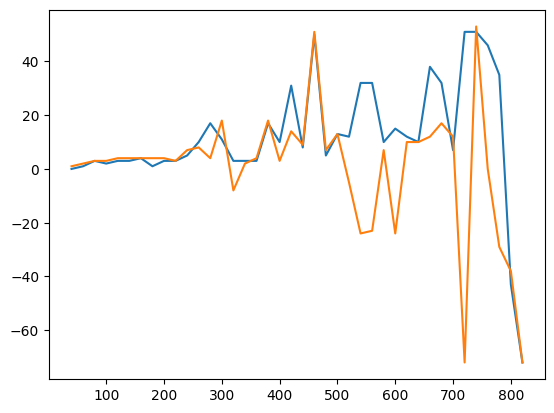

In [126]:
plt.plot(depths, lag_max_heat)
plt.plot(depths, lag_max_wind)

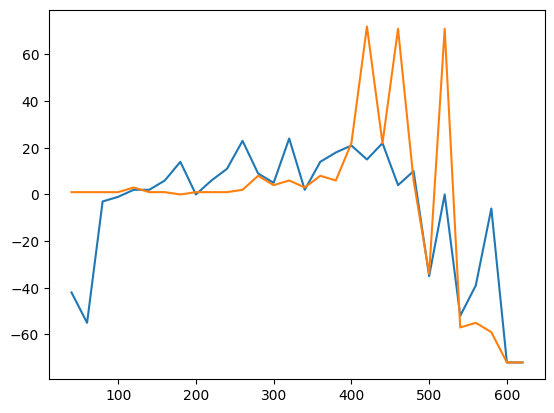

In [139]:
plt.plot(depths, lag_max_heat)
plt.plot(depths, lag_max_wind)

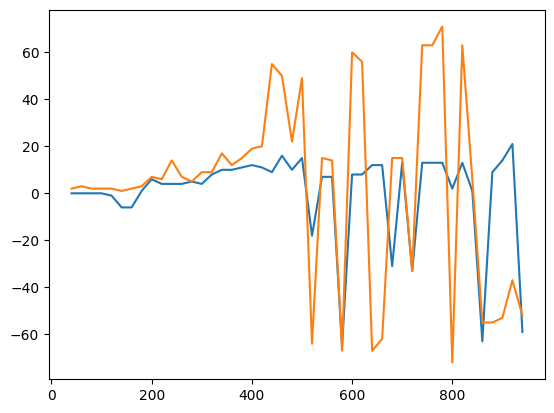

In [145]:
plt.plot(depths, lag_max_heat)
plt.plot(depths, lag_max_wind)

0


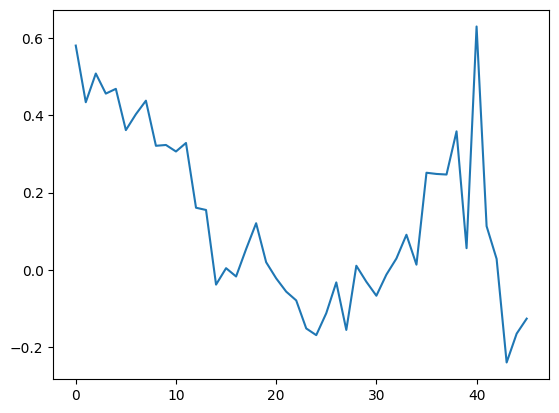

In [147]:
print(lags[int(len(lags)/2)])
plt.plot(corrs_heats[int(len(lags)/2),:])

# Get rid of daily cycle in heatflux --> It seems to make a difference for the very shallow MLD but I think I need to find another method to o that as the peaks stay

0 40.0 20.0
[range(-72, 73), range(-72, 73)] [[-0.38170409112425896, -0.17381544653356898, -0.13169209095551385, -0.11831543966226911, -0.11228557730390366, -0.05511585850464993, 0.021970723301279416, 0.02317093259994905, 0.02993690090872615, 0.09976478203363764, 0.13069969487836272, 0.14259214985685345, 0.17021664004608106, 0.1878579681345732, 0.23876005060694286, 0.24467562021538838, 0.2446520795835342, 0.24912806239666951, 0.2574029254190729, 0.2684024642785341, 0.26236611968219414, 0.2581154927958851, 0.2972165279917246, 0.3312535104257316, 0.37439593446526476, 0.4056819931493929, 0.42586563964384155, 0.4842604908908248, 0.5249540684061905, 0.5444957958701101, 0.573639628956698, 0.5974972028607031, 0.5866543234189235, 0.5541736283660043, 0.5244414566479845, 0.49822487843087576, 0.4567112649400849, 0.4211149010160805, 0.44141128462579377, 0.41911040079430156, 0.4149272450654372, 0.4407541972064059, 0.44181383980036404, 0.4134312290207937, 0.4155511546855563, 0.39705133950090254, 0.3

c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\m300892\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


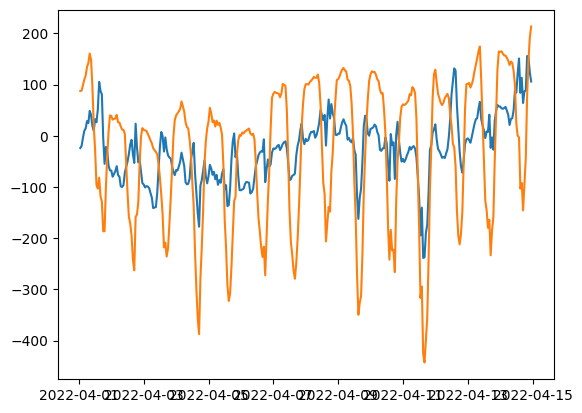

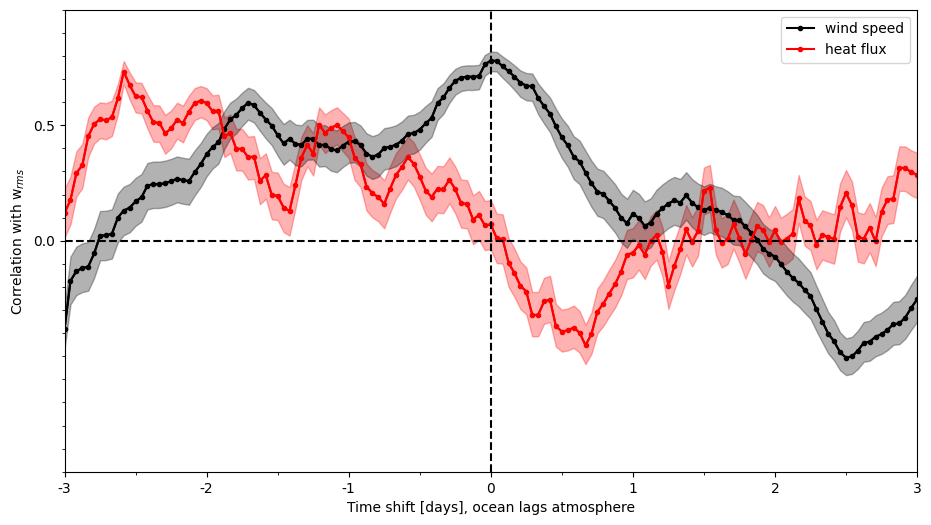

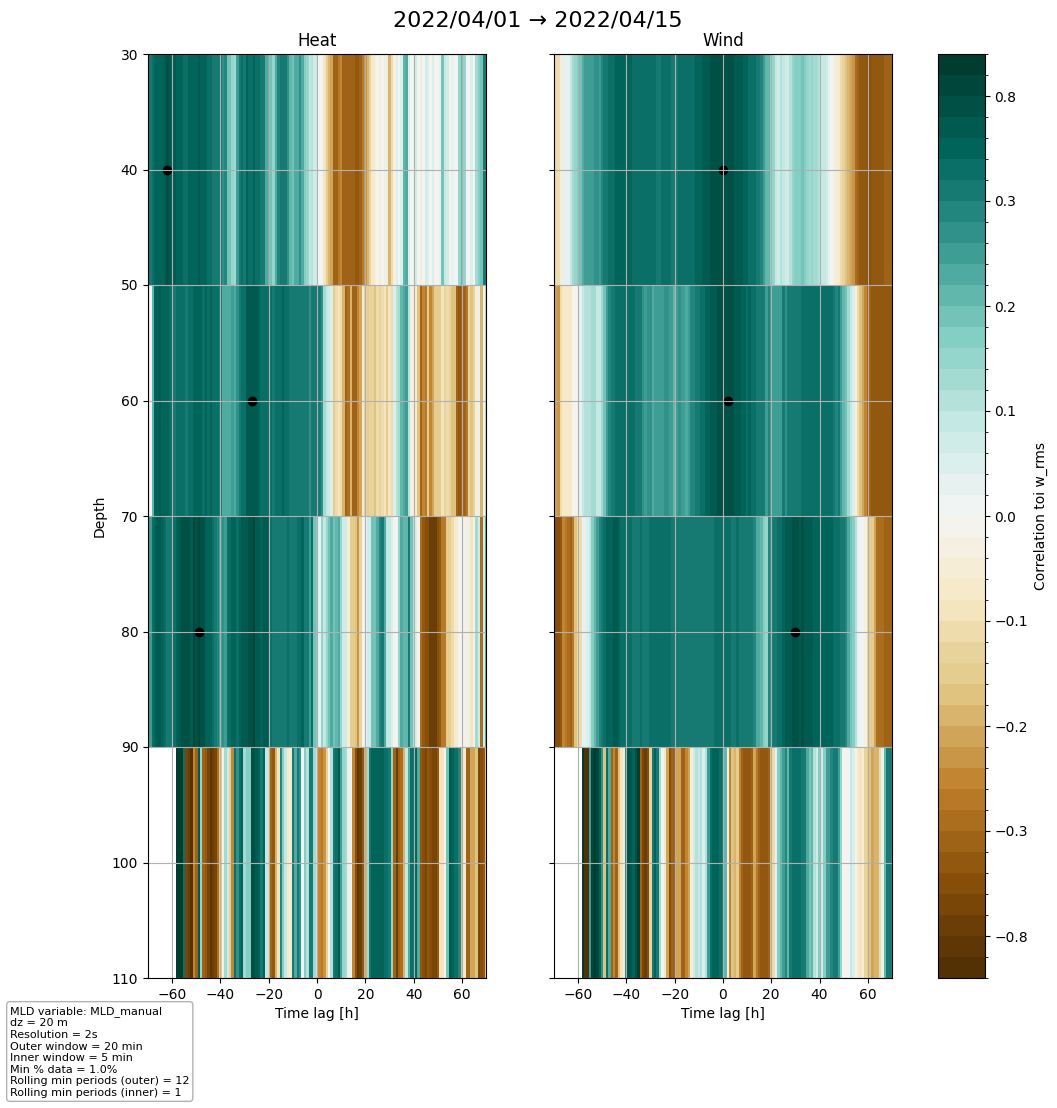

In [173]:
hourly_mean = series_wind.groupby(series_wind.index.hour).median()
# subtract the mean for the corresponding hour
series_wind_deseasoned = series_wind - series_wind.index.hour.map(hourly_mean) + np.nanmean(hourly_mean)

hourly_mean = series_heat.groupby(series_heat.index.hour).median() 
# subtract the mean for the corresponding hour
series_heat_deseasoned = series_heat - series_heat.index.hour.map(hourly_mean) + np.nanmean(hourly_mean)

plt.plot(series_heat_deseasoned)
plt.plot(series_heat)


lags  = range(-config['max_lag'], config['max_lag'] + 1)

ds_mld = ds_398.where((ds_398['depth'] < ds_398['MLD_manual']), drop=True)
depths = np.arange(config['depth_min']+dz,ds_mld['depth'].max()-dz,dz)


corrs_heats_deseason = np.full((len(lags),len(depths)), np.nan)
corrs_winds_deseason = np.full((len(lags),len(depths)), np.nan)
for i, depth_max in enumerate(depths):
    print(i,depth_max, depth_max-dz)
    ds_shallow = ds_mld.where((ds_mld['depth'] <= depth_max) & (ds_mld['depth']>depth_max-dz) , drop=True) #

    series_w_prime_shallow, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_shallow, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
    # Calculate vertical velocity variance without any masking
    wprime_rms_shallow                                                      = tools.get_wprime_timeseries(resample_time, ds_shallow, config, return_mask=False)
    lags, corrs_heat            = tools.lag_correlation(wprime_rms_shallow, series_heat_deseasoned, max_lag=config['max_lag'])
    lags_wind, corrs_wind       = tools.lag_correlation(wprime_rms_shallow, series_wind_deseasoned, max_lag=config['max_lag'])


    corrs_heats_deseason[:,i] = corrs_heat
    corrs_winds_deseason[:,i] = corrs_wind
    if i==0:
        # Plot the correlation
        corr_dict2 = {'lags':            [lags, lags], 
                    'correlations':     [corrs_wind, corrs_heat],
                    'labels':           ['wind speed', 'heat flux'],}
        plot_dict2 = {'ylim':(-1,1), 'colors': ['k','red'], 'xlim': [-24*3, 24*3]}
        fig, ax = plotters.plot_corr(corr_dict2, plot_dict2)
        upper_r, lower_r = tools.confid_interval(corrs_heat, len(series_heat))
        upper_r_interp, lower_r_interp = tools.confid_interval(corrs_wind, len(series_heat))
        ax.fill_between(lags, upper_r, lower_r, color='r', alpha=0.3)
        ax.fill_between(lags, upper_r_interp, lower_r_interp, color='k', alpha=0.3)
        fig.savefig(obsidiandirec + f'churchill_time_lag{config['start_time'].strftime('%Y%m%d')}_{config['end_time'].strftime('%Y%m%d')}_{depth_max-dz}_{depth_max}dbar_deseasoned.png')

# define the negative side
level1 = np.arange(-1, -0.3, 0.1)   # coarse far from 0
level2 = np.arange(-0.3, 0, 0.02)    # finer near 0
# include zero explicitly
levels_neg = np.concatenate([level1, level2])
levels = np.concatenate([levels_neg, [0], -levels_neg[::-1]])  # mirror to positive side

fig, (ax,ax2) = plt.subplots(1,2, figsize=(12,12), sharex=True, sharey=True)

cmap = palette.colorbrewer.diverging.BrBG_11.mpl_colormap
# Create norm with discrete levels
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
props = dict(norm=norm, cmap=cmap)
ax.pcolormesh(lags, depths, corrs_heats_deseason.T, **props)
cbar=ax2.pcolormesh(lags, depths, corrs_winds_deseason.T, **props)
fig.colorbar(cbar, ax=[ax,ax2], label='Correlation toi w_rms')

ax.invert_yaxis()
ax.grid()
ax2.grid()
ax2.set_xlabel('Time lag [h]')
ax.set_xlabel('Time lag [h]')
ax2.set_title('Wind')
ax.set_title('Heat')
ax.set_ylabel('Depth')
fig.supxlabel(
    f"{config['start_time'].strftime('%Y/%m/%d')} → {config['end_time'].strftime('%Y/%m/%d')}",
    fontsize=16, y=0.9, x=0.45  # adjust y to control vertical offset
)


# make a nice multi-line string from the config
textstr = (
    # f"Glider: {glidername}\n"
    f"MLD variable: {mld_var}\n"
    f"dz = {dz} m\n"
    f"Resolution = {resolution}s\n"
    f"Outer window = {outer_window_min} min\n"
    f"Inner window = {inner_window_min} min\n"
    f"Min % data = {min_perc*100:.1f}%\n"
    f"Rolling min periods (outer) = {config['rolling_min_periods_outer']}\n"
    f"Rolling min periods (inner) = {config['rolling_min_periods_inner']}"
    # f"Time range: {eddy1.date()} → {eddy2.date()}"
)
# add text at figure level (outside the axes)
fig.text(
    0.01, 0.01, textstr,
    fontsize=8, va="bottom", ha="left",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.6, edgecolor="gray")
)
ax.set_xlim(-70,70)
argmax1 = np.argmax(corrs_heats_deseason, axis=0)
argmax2 = np.argmax(corrs_winds_deseason, axis=0)
lag_max_wind = np.full(len(depths),np.nan)
lag_max_heat = np.full(len(depths),np.nan)
for i,depth in enumerate(depths):
    ax.scatter(lags[argmax1[i]], depth, c='k')
    ax2.scatter(lags[argmax2[i]], depth, c='k')
    lag_max_wind[i] = lags[argmax2[i]]
    lag_max_heat[i] = lags[argmax1[i]]
fig.savefig(obsidiandirec + f'churchill_time_lag{config['start_time'].strftime('%Y%m%d')}_{config['end_time'].strftime('%Y%m%d')}_deseasoned.png')


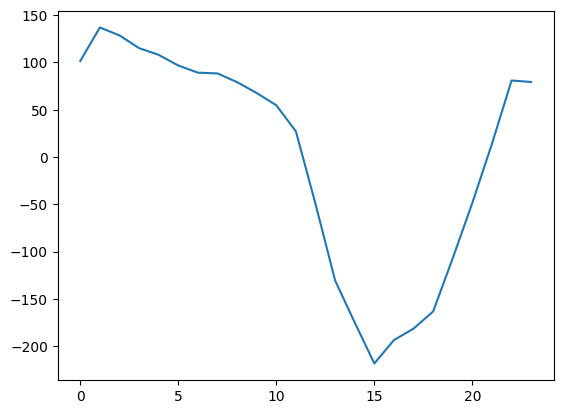

In [154]:
plt.plot(hourly_mean- np.nanmean(hourly_mean)) 

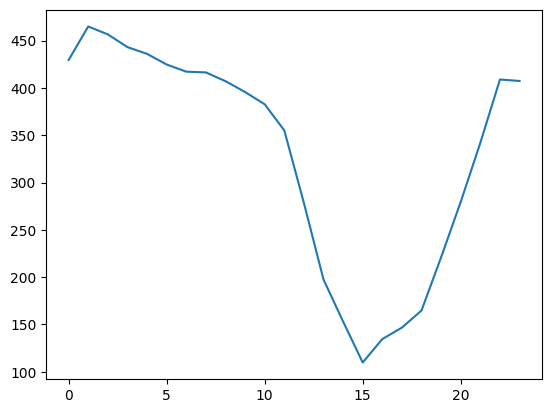

In [152]:
plt.plot(hourly_mean)

## Calculate time lags over time for different depths

In [ ]:
config = {
    "rolling_window_outer"     : f"{outer_window_min}min",           # 6H choosen by Steffen
    "rolling_window_inner"     : f"{inner_window_min}min",           # 1H, choosen by steffen's
    "rolling_min_periods_outer": int(outer_window_min*min_perc*60),  # Minimum number of observations within the outer rolling window (data before: in hours or see inner window)
    "rolling_min_periods_inner": int((inner_window_min/60)*(3600*1/resolution)*min_perc),  # Minimum number of observations within the inner rolling window (data before: in seconds or see most common time difference)
    
    "var"               : 'w',
    "data_in"           : ds, 
    "data_wind"         : ds_wind,
    "data_heat"         : ds_heat,
    "start_time"        : start, 
    "end_time"          : end, 
    "interp_method"     : "linear",
    "depth_min"         : 20,  # Drop upper 50m (wave effects, etc.)
    "max_lag"           : 24 * 3,
    "freq"              : 'H',
    "add_ext_interp"    : False, #True,
    "variables_to_keep" : ['salinity', 'temperature', 'density', 'depth', 'latitude', 'longitude', 'time', 'MLD', 'w', 'profile_direction', 'MLD_manual', 'profile_index'], #if None it keeps the standard variables
}
# Preprocess data
ds_398                                                          = tools.preprocess_data(config)
# Interpolate ERA5 onto hourly positions of the glider
resample_time, series_wind, series_heat                         = tools.interpolate_onto_track(ds_398, config)

lags  = range(-config['max_lag'], config['max_lag'] + 1)

ds_mld = ds_398.where((ds_398['depth'] < ds_398['MLD_manual']), drop=True)
depths = np.arange(config['depth_min']+dz,ds_mld['depth'].max()-dz,dz)


corrs_heats = np.full((len(lags),len(depths)), np.nan)
corrs_winds = np.full((len(lags),len(depths)), np.nan)
for i, depth_max in enumerate(depths):
    print(i,depth_max, depth_max-dz)
    ds_shallow = ds_mld.where((ds_mld['depth'] <= depth_max) & (ds_mld['depth']>depth_max-dz) , drop=True) #

    series_w_prime_shallow, gap_mask, intermediates                         = tools.get_wprime_timeseries_update_3(resample_time,ds_shallow, config, debug=True, mld_var=mld_var) # max_gap_duration=np.timedelta64(1, "h"),
    # Calculate vertical velocity variance without any masking
    wprime_rms_shallow                                                      = tools.get_wprime_timeseries(resample_time, ds_shallow, config, return_mask=False)
    lags, corrs_heat            = tools.lag_correlation(wprime_rms_shallow, series_heat, max_lag=config['max_lag'])
    lags_wind, corrs_wind       = tools.lag_correlation(wprime_rms_shallow, series_wind, max_lag=config['max_lag'])


    corrs_heats[:,i] = corrs_heat
    corrs_winds[:,i] = corrs_wind